Sample ID: HCR 3.11 S3  
Section: 200um coronal section from ALM  
Mouse: ANM471122 C57BI/6NCrl, sex M, DOB 10/21/2019  
Genes labelled: Vip (514 channel), Tac2 (546 channel), Npy2r (594 channel), Car4 (647 channel)  
Microscope: Zeiss 880 (regular confocal mode)  
Objective: 40X oil immersion 

# Setup

## Imports

In [4]:
%matplotlib notebook   

# Create a Qt event loop for napari
from IPython import get_ipython
ipython = get_ipython()
ipython.magic("gui qt5")             

import napari
from PIL import Image

import numpy as np
import cv2

import matplotlib.pyplot as plt

import time

from os.path import sep
import pickle as pkl
import importlib

import get_metadata

from utils import diff_gauss
from utils import find_threshold

from segmentation import get_masks
from segmentation import get_background

from plotting import napari_rendering
from plotting import scatter_plots
from plotting import view_all_cells

from lipofuscin import annotated_lipo_rois
from lipofuscin import filter_lipo
from lipofuscin import detect

from expression import signal_and_bg

from classification import get_labels

from cell_depths import get_depths

# Enable autoreload of local modules
%load_ext autoreload
%autoreload 2        # Autoreload all modules except those excluded using %aimport
%aimport napari, PIL.Image, numpy, cv2, matplotlib.pyplot, time, importlib 

# from mpl_toolkits import mplot3d
# import matplotlib.colors as colors
# import matplotlib.path as mpltpath


# import h5py

# from bisect import bisect_left

# from skimage.measure import profile_line
# from skimage.filters import gaussian


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Specify data path

In [5]:
data_path = 'G:\\Shared drives\\as_share\\HCR\\HCR 3.11\\S3'
metadata_file = 'metadata.pkl'

## Metadata

In [6]:
um_per_px = 0.13

raw_image_path = '{0}{1}S3_raw_tiff_images'.format(data_path, sep)
seg_image_path = '{0}{1}S5_blurred_tiff_images'.format(data_path, sep)
plots_path = '{0}{1}Plots'.format(data_path, sep)
filt_image_path = '{0}{1}Filtered_tiff_images'.format(data_path, sep)

plane_nos = range(1, 11)
base_filename = 'S3_z'
genes = ['Vip', 'Tac2', 'Car4', 'Npy2r']
channel_names = {'Vip': '_ChS1-T3_ORG',
                 'Tac2': '_ChS2-T1_ORG',
                 'Npy2r': '_ChS2-T3_ORG',
                 'Car4': '_ChS2-T2_ORG'}
n_planes = len(plane_nos)
print('Number of planes: {0}'.format(n_planes))

# Create 4D array to store images
img = Image.open('{0}{1}{2}{3}{4}.tif'.format(raw_image_path, sep, base_filename, str(plane_nos[0]).zfill(2),
                                             channel_names[genes[0]]))

h = img.height
w = img.width

metadata = get_metadata.get_metadata(data_path, metadata_file, um_per_px, raw_image_path, seg_image_path, plots_path,
                                    filt_image_path, plane_nos, base_filename, genes, channel_names, n_planes, h, w)



Number of planes: 10


# Napari rendering

In [61]:
# Create viewer
viewer = napari_rendering.create_viewer()

##### Images

In [62]:
# Raw images
napari_rendering.images(data_path, metadata_file, viewer, planes = [0, 1, 2])

Loading Vip images: 0.0 seconds
     Plane 1, 0.0 seconds
     Plane 2, 1.0 seconds
     Plane 3, 2.0 seconds
Loading Tac2 images: 5.0 seconds
     Plane 1, 5.0 seconds
     Plane 2, 6.0 seconds
     Plane 3, 7.0 seconds
Loading Car4 images: 9.0 seconds
     Plane 1, 9.0 seconds
     Plane 2, 10.0 seconds
     Plane 3, 11.0 seconds
Loading Npy2r images: 14.0 seconds
     Plane 1, 14.0 seconds
     Plane 2, 14.0 seconds
     Plane 3, 16.0 seconds


In [68]:
# Filtered images
napari_rendering.filt_images(data_path, metadata_file, viewer, planes = [0, 1, 2], 
                             image_type = 'lipo_filt',
                            colors = ['green', 'red', 'magenta', 'blue'],
                            )

Loading Vip images: 0.0 seconds
     Plane 1, 0.0 seconds
     Plane 2, 1.0 seconds
     Plane 3, 2.0 seconds
Loading Tac2 images: 5.0 seconds
     Plane 1, 5.0 seconds
     Plane 2, 6.0 seconds
     Plane 3, 7.0 seconds
Loading Car4 images: 10.0 seconds
     Plane 1, 10.0 seconds
     Plane 2, 11.0 seconds
     Plane 3, 12.0 seconds
Loading Npy2r images: 14.0 seconds
     Plane 1, 14.0 seconds
     Plane 2, 16.0 seconds
     Plane 3, 17.0 seconds


##### Cell masks

In [70]:
napari_rendering.cell_masks(data_path, metadata_file, viewer, planes = [0, 1, 2])

Cell 10
Cell 10
Cell 30
Cell 10
Cell 20
Cell 30
Cell 20
Cell 40
Cell 50


##### Annotated lipofuscin rois

In [71]:
napari_rendering.lipo_rois(data_path, metadata_file, viewer, planes = [0, 1, 2])

##### Masks with lipofuscin exluded

In [72]:
napari_rendering.no_lipo_masks(data_path, metadata_file, viewer, planes = [0, 1, 2])

# Segmentation

## Get cell pixels

In [7]:
cell_data, n_cells = get_masks.get_masks(data_path, metadata_file)
cell_pixels = get_masks.get_cell_pixels(data_path, metadata_file)
all_cell_pixels = get_masks.get_all_cell_pixels(data_path, metadata_file)

135 cell masks found
Cell pixels found in G:\Shared drives\as_share\HCR\HCR 3.11\S3\cell_pixels.pkl
Cell pixels found in G:\Shared drives\as_share\HCR\HCR 3.11\S3\all_cell_pixels.pkl


## Get background pixels

In [9]:
bg_pixels, centers = get_background.get_bg_pixels(data_path, metadata_file)
#all_bg_pixels = get_background.get_all_bg_pixels(data_path, metadata_file)

Background pixels found in G:\Shared drives\as_share\HCR\HCR 3.11\S3\bg_pixels.pkl


## Segment cells

# Lipofuscin exclusion

## Annotated lipofuscin rois

In [10]:
# Load existing rois
l_rois = annotated_lipo_rois.get_rois(data_path, metadata_file)
all_lipo_pixels, lipo_pixels_roi = annotated_lipo_rois.get_cell_lipo_pixels(data_path, metadata_file)

6 rois
Data loaded


##### Draw new rois

In [64]:
viewer.add_shapes(data = None, name = 'Lipofuscin rois', edge_color = 'white')

<Shapes layer 'Lipofuscin ROIs' at 0x1f589b08>

In [73]:
try:
    with open('{0}{1}{2}'.format(data_path, sep, metadata['lipo_rois_file']), 'rb') as f:
        l_rois = pkl.load(f) 
    l_rois = np.append(l_rois, viewer.layers['Lipofuscin rois'].data, axis = 0)
except:
    l_rois = viewer.layers['Lipofuscin rois'].data
    
with open('{0}{1}{2}'.format(data_path, sep, metadata['lipo_rois_file']), 'wb') as f:
    pkl.dump(l_rois, f) 
    
n_rois = len(l_rois)
print('{0} lipofuscin rois'.format(n_rois))

6 lipofuscin rois


## Detect lipofuscin rois in cells and background

In [ ]:
# Filter images - 5.5 min
cell_filt_values, bg_filt_values, anno_lipo_filt_values = filter_lipo.filter(data_path, metadata_file, 
                                                                                  thresh_scale = 1,
                                                                                  save_tiffs = True,
                                                                                 rect = crop.data[-1],
                                                                                #planes = [1, 2],
                                                                                 #genes = ['Vip'],
                                                                             verbose = False,
                                                                             do_plot = True,
                                                                                 )



Could not load pixel values in filtered images. Filtering raw images

Filtering Vip images: 0.0 seconds
Saving plane 0: 8.0 seconds
Saving plane 1: 17.0 seconds
Saving plane 2: 27.0 seconds
Saving plane 3: 37.0 seconds
Saving plane 4: 46.0 seconds
Saving plane 5: 55.0 seconds
Saving plane 6: 65.0 seconds


In [50]:
# Get mahalanobis distance from lipofuscin pixels
m_dist_cells, m_dist_bg, m_dist_lipo = detect.get_m_dist(data_path, metadata_file)

Text(0, 0.5, 'Number of pixels')

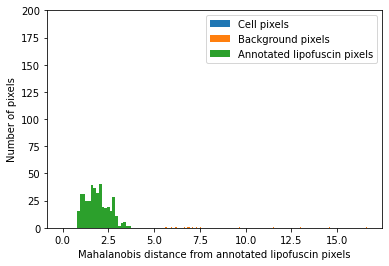

In [51]:
cell = 95
plane = cell_data[cell]['z_planes'][0]

plt.figure()
plt.hist(m_dist_cells[cell][plane], 100, label = 'Cell pixels')
plt.hist(m_dist_bg[cell][plane], 2500, label = 'Background pixels')
plt.hist(m_dist_lipo, 20, label = 'Annotated lipofuscin pixels')
plt.ylim([0, 200])
plt.legend()
plt.xlabel('Mahalanobis distance from annotated lipofuscin pixels')
plt.ylabel('Number of pixels')

In [52]:
cell_pixels_no_lipo, bg_pixels_no_lipo = detect.get_lipo(data_path, metadata_file, thresh_scale = 1.5)

# Measure expression

In [53]:
# Filter images and calculate signal (2.5 min)
signal_raw, signal_filt, bg_raw, bg_filt = signal_and_bg.get_signal_and_bg(data_path, metadata_file, save_tiffs = True)


Filtering Vip images: 0.0 seconds
Plane 1, 0.0 seconds
Saving plane 0: 5.0 seconds


C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\fish\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\fish\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cell 2 plane 0: all pixels excluded
Cell 15 plane 0: all pixels excluded
Cell 17 plane 0: all pixels excluded
Cell 18 plane 0: all pixels excluded
Cell 30 plane 0: all pixels excluded
Plane 2, 17.0 seconds
Saving plane 1: 22.0 seconds
Cell 22 plane 1: all pixels excluded
Cell 29 plane 1: all pixels excluded
Cell 34 plane 1: all pixels excluded
Plane 3, 34.0 seconds
Saving plane 2: 39.0 seconds
Cell 22 plane 2: all pixels excluded
Plane 4, 51.0 seconds
Saving plane 3: 56.0 seconds
Cell 59 plane 3: all pixels excluded
Cell 62 plane 3: all pixels excluded
Cell 64 plane 3: all pixels excluded
Cell 66 plane 3: all pixels excluded
Cell 68 plane 3: all pixels excluded
Plane 5, 68.0 seconds
Saving plane 4: 74.0 seconds
Cell 59 plane 4: all pixels excluded
Cell 64 plane 4: all pixels excluded
Cell 75 plane 4: all pixels excluded
Cell 82 plane 4: all pixels excluded
Plane 6, 85.0 seconds
Saving plane 5: 91.0 seconds
Cell 89 plane 5: all pixels excluded
Cell 90 plane 5: all pixels excluded
Cell 9

Saving plane 7: 645.0 seconds
Cell 93 plane 7: all pixels excluded
Cell 95 plane 7: all pixels excluded
Cell 98 plane 7: all pixels excluded
Cell 102 plane 7: all pixels excluded
Cell 106 plane 7: all pixels excluded
Cell 107 plane 7: all pixels excluded
Cell 108 plane 7: all pixels excluded
Cell 110 plane 7: all pixels excluded
Cell 111 plane 7: all pixels excluded
Plane 9, 657.0 seconds
Saving plane 8: 664.0 seconds
Cell 102 plane 8: all pixels excluded
Cell 106 plane 8: all pixels excluded
Cell 107 plane 8: all pixels excluded
Cell 111 plane 8: all pixels excluded
Cell 124 plane 8: all pixels excluded
Plane 10, 676.0 seconds
Saving plane 9: 681.0 seconds
Cell 125 plane 9: all pixels excluded
Cell 126 plane 9: all pixels excluded
Cell 135 plane 9: all pixels excluded


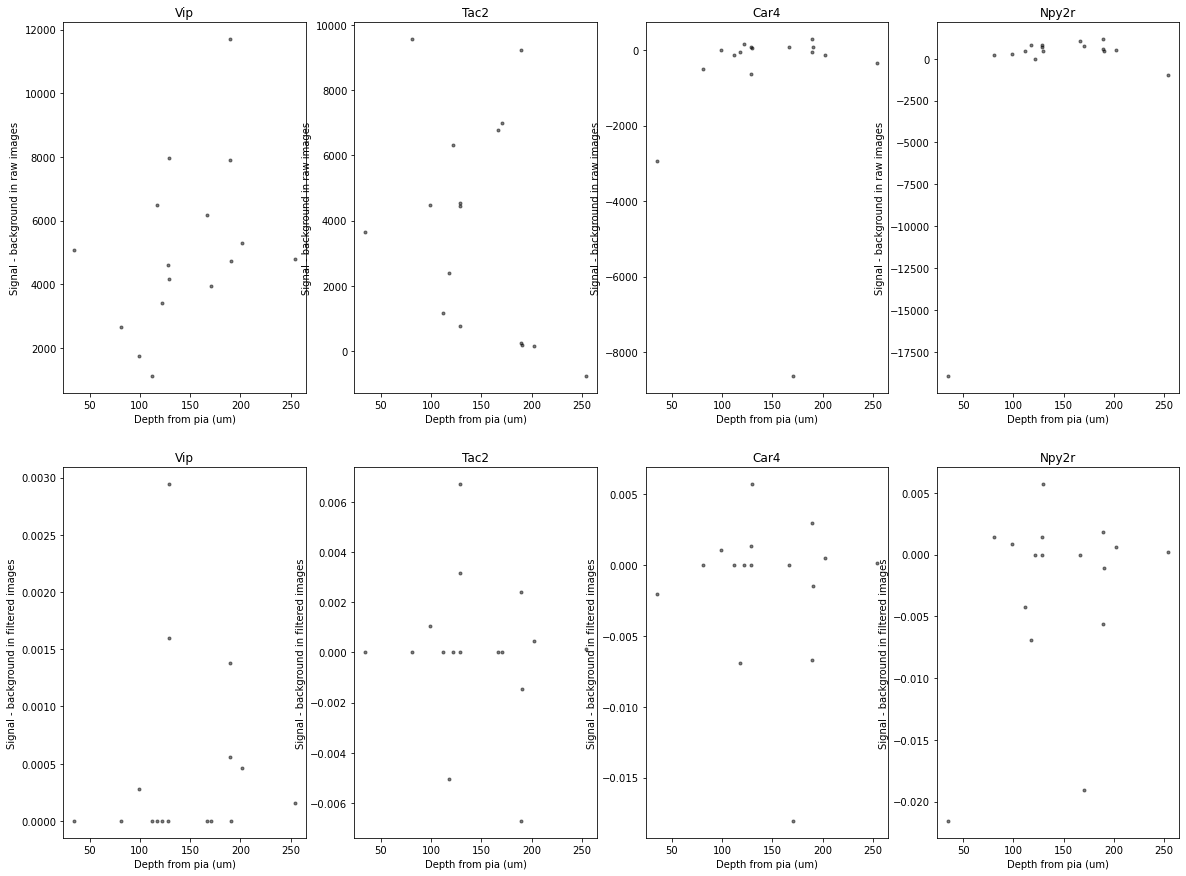

In [54]:
# Plot signal
scatter_plots.signal_vs_depth(data_path, metadata_file)

# Cell depths

In [204]:
# Draw surface of cortex
surface_layer = get_depths.draw_surface(data_path, metadata_file, viewer)

Depths loaded


Text(0, 0.5, '# cells')

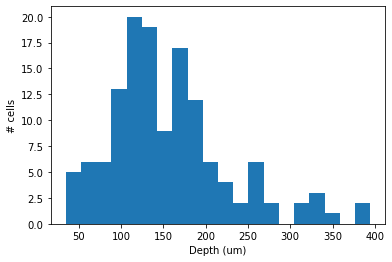

In [57]:
# Calculate depths
depths = get_depths.get_depths(data_path, metadata_file)
plt.figure()
plt.hist(depths, 20)
plt.xlabel('Depth (um)')
plt.ylabel('# cells')

# Classification

In [58]:
bs_raw, bs_filt = get_labels.get_bootstrap(data_path, metadata_file)

Loading Vip images: 0.0 seconds
Cell 1 plane 0: all pixels excluded from cell or background
Cell 2 plane 0: all pixels excluded from cell or background
Cell 3 plane 0: all pixels excluded from cell or background
Cell 4 plane 0: all pixels excluded from cell or background
Cell 5 plane 0: all pixels excluded from cell or background
Cell 6 plane 0: all pixels excluded from cell or background
Cell 7 plane 0: all pixels excluded from cell or background
Cell 8 plane 0: all pixels excluded from cell or background
Cell 9 plane 0: all pixels excluded from cell or background
Cell 11 plane 0: all pixels excluded from cell or background
Cell 12 plane 0: all pixels excluded from cell or background
Cell 13 plane 0: all pixels excluded from cell or background
Cell 14 plane 0: all pixels excluded from cell or background
Cell 15 plane 0: all pixels excluded from cell or background
Cell 16 plane 0: all pixels excluded from cell or background
Cell 17 plane 0: all pixels excluded from cell or background
C

Cell 102 plane 8: all pixels excluded from cell or background
Cell 106 plane 8: all pixels excluded from cell or background
Cell 107 plane 8: all pixels excluded from cell or background
Cell 108 plane 8: all pixels excluded from cell or background
Cell 109 plane 8: all pixels excluded from cell or background
Cell 111 plane 8: all pixels excluded from cell or background
Cell 112 plane 8: all pixels excluded from cell or background
Cell 113 plane 8: all pixels excluded from cell or background
Cell 117 plane 8: all pixels excluded from cell or background
Cell 118 plane 8: all pixels excluded from cell or background
Cell 119 plane 8: all pixels excluded from cell or background
Cell 120 plane 8: all pixels excluded from cell or background
Cell 121 plane 8: all pixels excluded from cell or background
Cell 122 plane 8: all pixels excluded from cell or background
Cell 124 plane 8: all pixels excluded from cell or background
Cell 117 plane 9: all pixels excluded from cell or background
Cell 118

Cell 73 plane 6: all pixels excluded from cell or background
Cell 84 plane 6: all pixels excluded from cell or background
Cell 85 plane 6: all pixels excluded from cell or background
Cell 88 plane 6: all pixels excluded from cell or background
Cell 89 plane 6: all pixels excluded from cell or background
Cell 90 plane 6: all pixels excluded from cell or background
Cell 92 plane 6: all pixels excluded from cell or background
Cell 93 plane 6: all pixels excluded from cell or background
Cell 94 plane 6: all pixels excluded from cell or background
Cell 96 plane 6: all pixels excluded from cell or background
Cell 97 plane 6: all pixels excluded from cell or background
Cell 98 plane 6: all pixels excluded from cell or background
Cell 98 plane 6: all pixels excluded from cell or background
Cell 99 plane 6: all pixels excluded from cell or background
Cell 100 plane 6: all pixels excluded from cell or background
Cell 115 plane 6: all pixels excluded from cell or background
Cell 93 plane 7: all p

Cell 55 plane 4: all pixels excluded from cell or background
Cell 59 plane 4: all pixels excluded from cell or background
Cell 60 plane 4: all pixels excluded from cell or background
Cell 61 plane 4: all pixels excluded from cell or background
Cell 63 plane 4: all pixels excluded from cell or background
Cell 64 plane 4: all pixels excluded from cell or background
Cell 69 plane 4: all pixels excluded from cell or background
Cell 69 plane 4: all pixels excluded from cell or background
Cell 70 plane 4: all pixels excluded from cell or background
Cell 70 plane 4: all pixels excluded from cell or background
Cell 72 plane 4: all pixels excluded from cell or background
Cell 73 plane 4: all pixels excluded from cell or background
Cell 75 plane 4: all pixels excluded from cell or background
Cell 76 plane 4: all pixels excluded from cell or background
Cell 78 plane 4: all pixels excluded from cell or background
Cell 79 plane 4: all pixels excluded from cell or background
Cell 80 plane 4: all pix

Cell 40 plane 3: all pixels excluded from cell or background
Cell 43 plane 3: all pixels excluded from cell or background
Cell 45 plane 3: all pixels excluded from cell or background
Cell 47 plane 3: all pixels excluded from cell or background
Cell 50 plane 3: all pixels excluded from cell or background
Cell 52 plane 3: all pixels excluded from cell or background
Cell 53 plane 3: all pixels excluded from cell or background
Cell 55 plane 3: all pixels excluded from cell or background
Cell 57 plane 3: all pixels excluded from cell or background
Cell 58 plane 3: all pixels excluded from cell or background
Cell 59 plane 3: all pixels excluded from cell or background
Cell 60 plane 3: all pixels excluded from cell or background
Cell 61 plane 3: all pixels excluded from cell or background
Cell 62 plane 3: all pixels excluded from cell or background
Cell 63 plane 3: all pixels excluded from cell or background
Cell 64 plane 3: all pixels excluded from cell or background
Cell 65 plane 3: all pix

# View images of cells

## Tac2

IndexError: too many indices for array

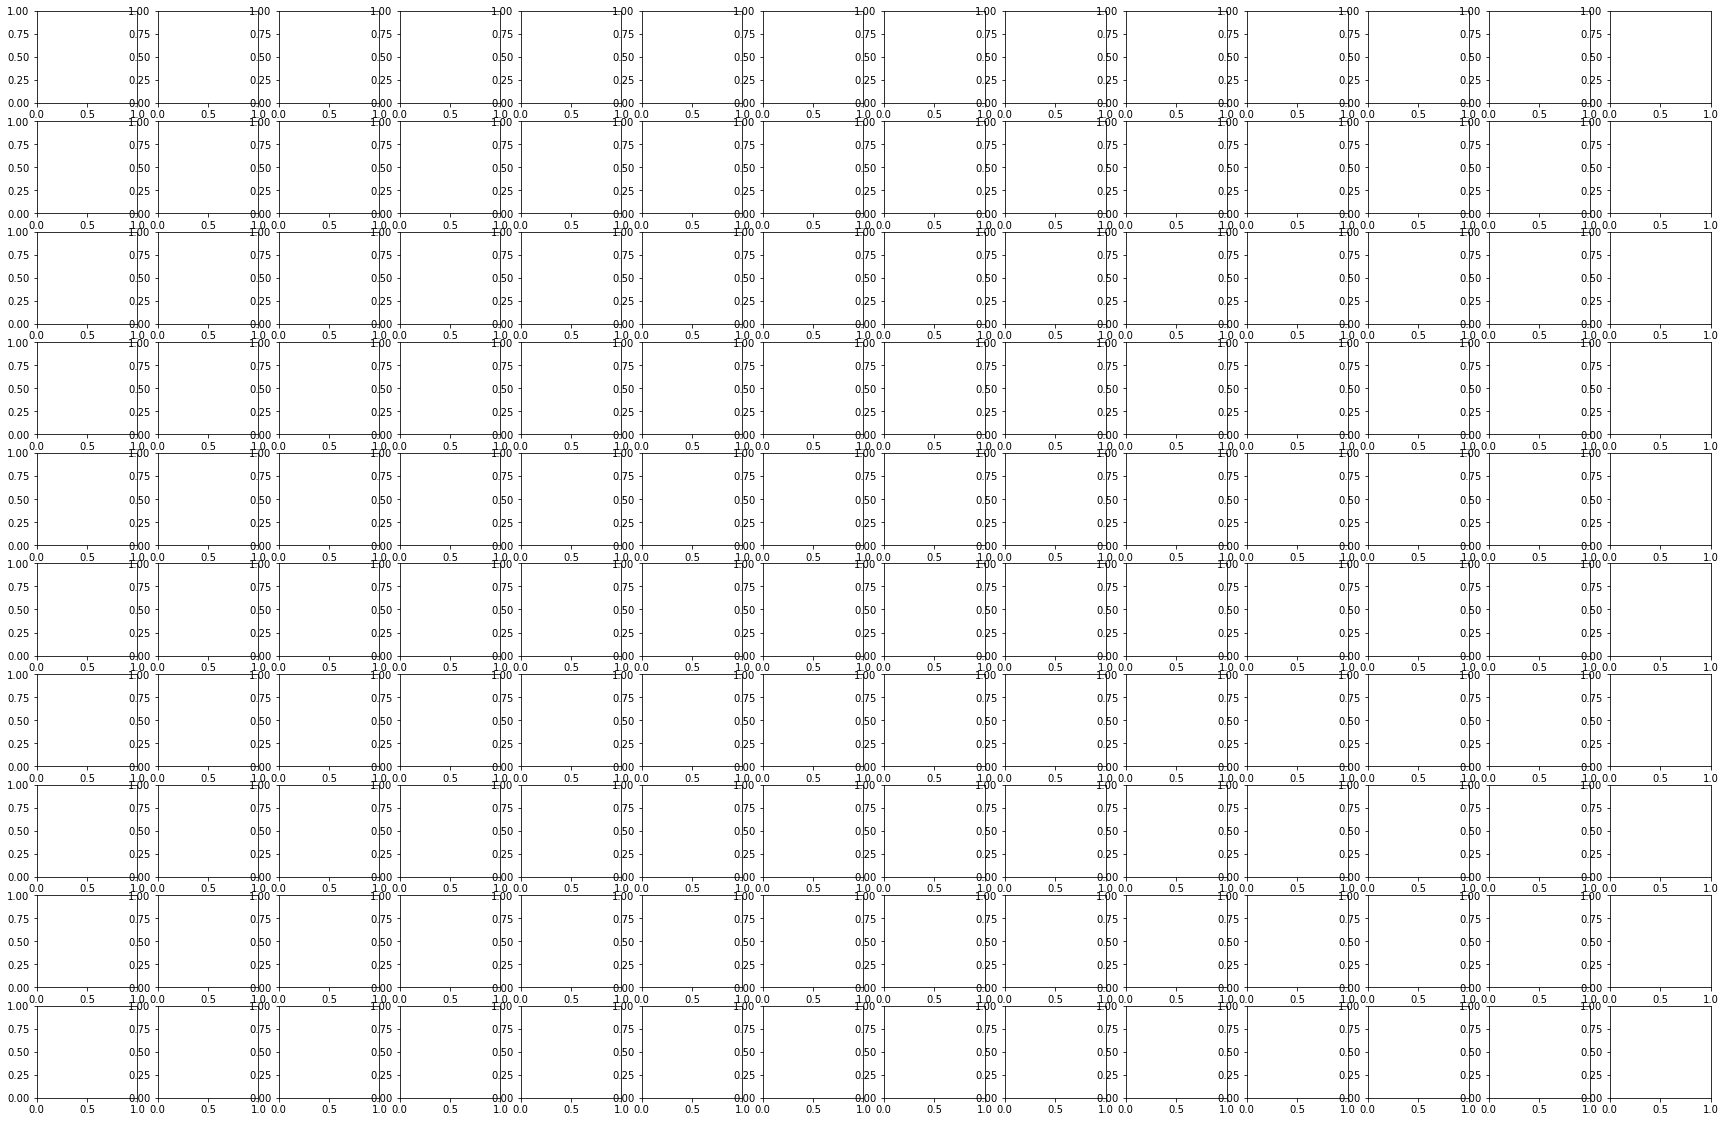

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import sep
import pickle as pkl
import time
from PIL import Image

n_rows = 10 
n_cols = 14 
size_um = 20 
spine_color_pos = 'r'
spine_width = 2
show_masks = False
max_intensity = None
genes = ['Tac2']
pos_cells = []

# Load metadata
with open('{0}{1}{2}'.format(data_path, sep, metadata_file), 'rb') as f:
    metadata = pkl.load(f)
raw_image_path = metadata['raw_image_path']
filt_image_path = metadata['filt_image_path']
um_per_px = metadata['um_per_px']
n_planes = metadata['n_planes']
h = metadata['h']
w = metadata['w']
base_filename = metadata['base_filename']
channel_names = metadata['channel_names']
if genes == None:
    genes = metadata['genes']

# Load cell pixels
cell_data_file = metadata['cell_data_file']
with open('{0}{1}{2}'.format(data_path, sep, cell_data_file), 'rb') as f:
    cell_data = pkl.load(f)

# Load background pixels
bg_pixels_no_lipo_file = metadata['bg_pixels_no_lipo_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_pixels_no_lipo_file), 'rb') as f:
    bg_pixels_no_lipo = pkl.load(f)

# Load signal
signal_raw_file = metadata['signal_raw_file']
with open('{0}{1}{2}'.format(data_path, sep, signal_raw_file), 'rb') as f:
    signal_raw = pkl.load(f)

signal_filt_file = metadata['signal_filt_file']
with open('{0}{1}{2}'.format(data_path, sep, signal_filt_file), 'rb') as f:
    signal_filt = pkl.load(f)

# Load background
bg_raw_file = metadata['bg_raw_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_raw_file), 'rb') as f:
    bg_raw = pkl.load(f)

bg_filt_file = metadata['bg_filt_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_filt_file), 'rb') as f:
    bg_filt = pkl.load(f)

cells = np.array(list(cell_data.keys()))
t0 = time.time()
for gene in genes:

    sig = signal_raw[gene]
    sig = np.array([np.mean([sig[cell][plane] for plane in sig[cell].keys()]) for cell in sig.keys()])
    sig[np.isnan(sig)] = np.zeros(np.sum(np.isnan(sig)))
    bg = bg_raw[gene]
    bg = np.array([np.mean([bg[cell][plane] for plane in bg[cell].keys()]) for cell in bg.keys()])
    bg[np.isnan(bg)] = np.zeros(np.sum(np.isnan(bg)))
    cell_order = cells[np.flip(np.argsort(sig - bg)).astype(int)]

    size_px = int(size_um/um_per_px/2)
    mask_dil =  np.zeros([h, w]).astype(bool)

#     im_array = np.zeros([n_planes, h, w])

#     for plane in range(n_planes):
#         print('Plane {0}, {1} seconds'.format(plane + 1, np.round(time.time() - t0)))
#         img = Image.open('{0}{1}{2}{3}{4}.tif'.format(raw_image_path, sep, base_filename, str(plane + 1).zfill(2),
#                                                         channel_names[gene]))
#         im_array[plane, :, :] = np.array(img)

    if max_intensity == None:
        max_intensity = np.max(sig)
    min_intensity = np.min(im_array)

    t0 = time.time()
    fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (30, 20))

    for cell in cells:

        if np.mod(cell, 10) == 0:
            print('Cell {0}: {1} seconds'.format(cell, np.round(time.time() - t0)))

        row = int((cell - 1)/n_cols)
        col = np.mod((cell - 1), n_cols)

        cell_id = cell_order[cell - 1]

        planes = cell_data[cell_id]['z_planes']
        med_plane = int(np.median(planes))

        mask = cell_data[cell_id]['masks'][med_plane]
        [x_center, y_center] = np.mean(mask, 0).astype(int)
        [x1, y1] = [np.max([0, x_center - size_px]), np.max([0, y_center - size_px])]
        [x2, y2] = [np.min([h, x_center + size_px]), np.min([w, y_center + size_px])]
        mask_dil[x1:x2, y1:y2] = np.ones([x2 - x1, y2 - y1])

        small_im = np.reshape(im_array[med_plane, mask_dil],
                                        [np.min([x2 - x1, size_px*2]),
                                        np.min([y2 - y1, size_px*2])])
        ax[row, col].imshow(small_im, vmin = min_intensity, vmax = max_intensity)

        mask_dil[x1:x2, y1:y2] = np.zeros([x2 - x1, y2 - y1])

        if col == 0:
            ax[row, col].set_ylabel('{0}'.format(np.round(sig[cell_id - 1] - bg[cell_id - 1], 2)))
#             ax[row, col].axis('on')

        if len(pos_cells) > 0:
            if pos_cells[cell] == 1:
                ax[row, col].axis('on')
                ax[row, col].spines['bottom'].set_color(spine_color_pos)
                ax[row, col].spines['top'].set_color(spine_color_pos)
                ax[row, col].spines['left'].set_color(spine_color_pos)
                ax[row, col].spines['right'].set_color(spine_color_pos)
                ax[row, col].spines['bottom'].set_linewidth(spine_width)
                ax[row, col].spines['top'].set_linewidth(spine_width)
                ax[row, col].spines['left'].set_linewidth(spine_width)
                ax[row, col].spines['right'].set_linewidth(spine_width)

        ax[row, col].tick_params(axis = 'both', which = 'both', bottom = False, top = False, left = False,
                                 right = False, labeltop = False, labelright = False, labelleft = False,
                                labelbottom = False)


## Npy2r

Plane 1, 0.0 seconds
Plane 2, 1.0 seconds
Plane 3, 2.0 seconds
Plane 4, 3.0 seconds
Plane 5, 4.0 seconds
Plane 6, 6.0 seconds
Plane 7, 7.0 seconds
Plane 8, 7.0 seconds
Plane 9, 8.0 seconds
Plane 10, 9.0 seconds
Cell 10: 2.0 seconds
Cell 20: 3.0 seconds
Cell 30: 3.0 seconds
Cell 40: 4.0 seconds
Cell 50: 5.0 seconds
Cell 60: 5.0 seconds
Cell 70: 6.0 seconds
Cell 80: 7.0 seconds
Cell 90: 7.0 seconds
Cell 100: 8.0 seconds
Cell 110: 9.0 seconds
Cell 120: 9.0 seconds
Cell 130: 10.0 seconds


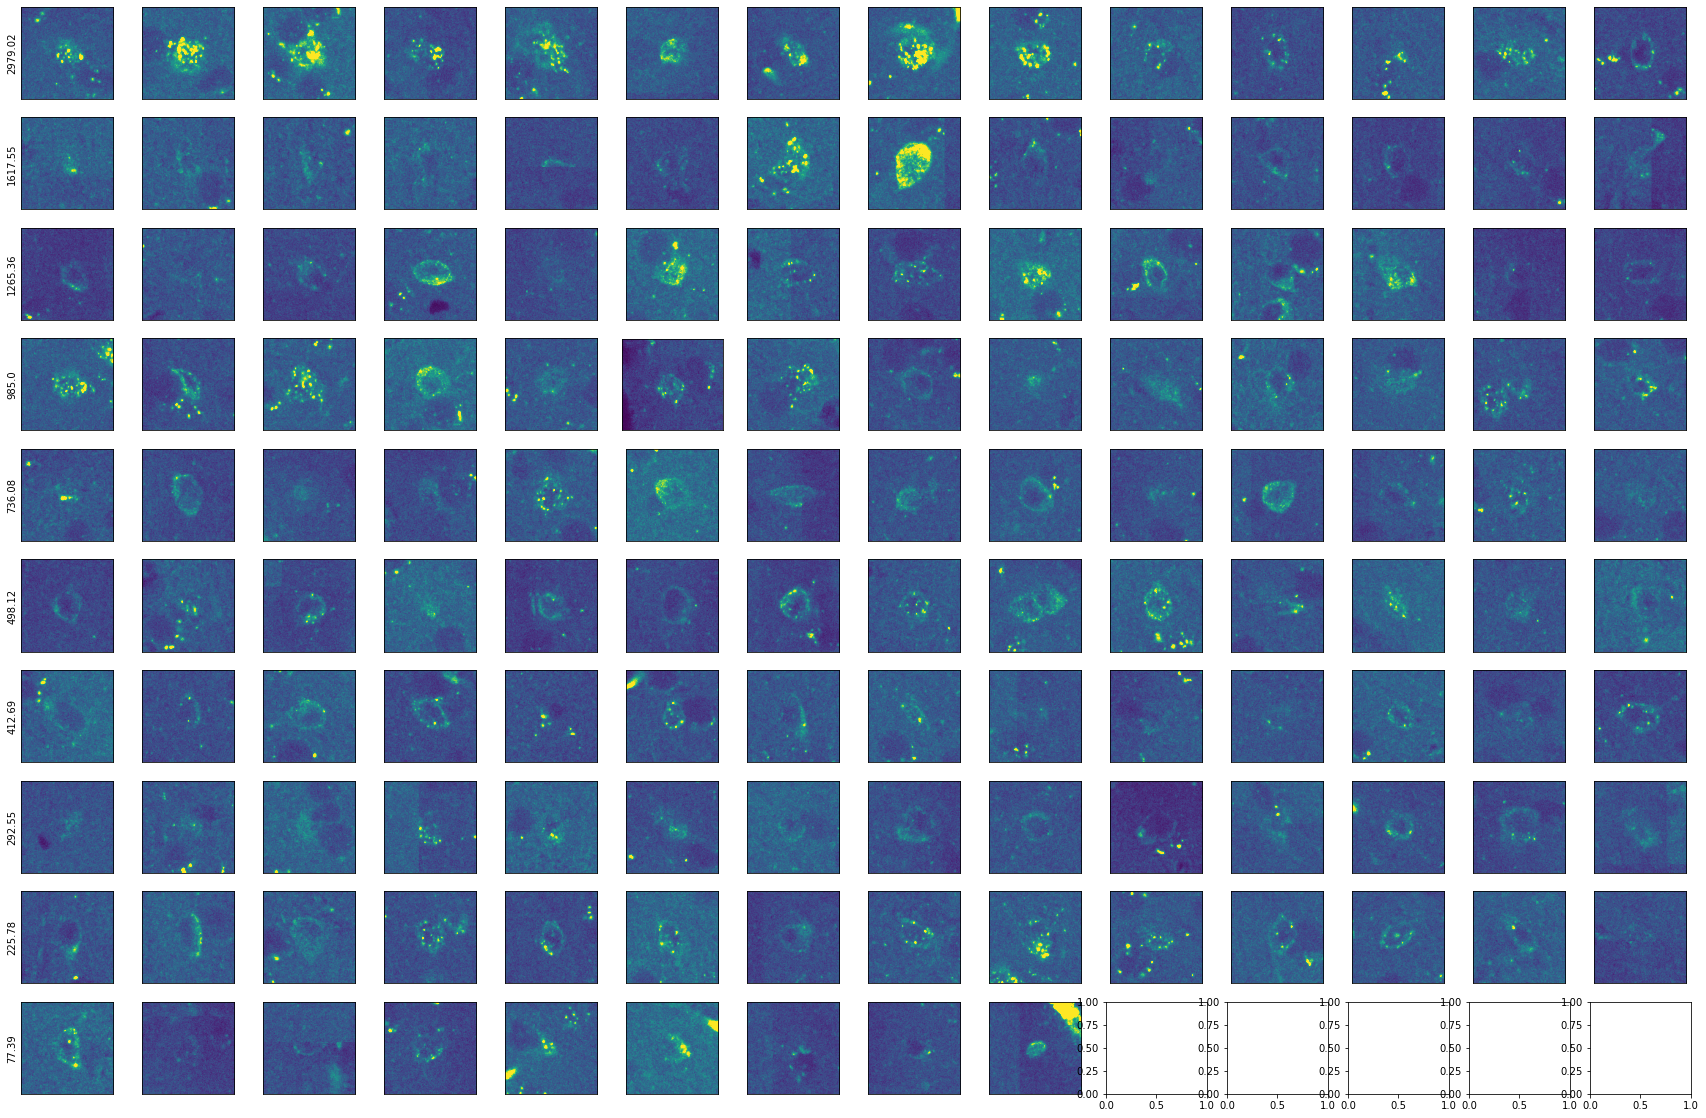

In [375]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import sep
import pickle as pkl
import time
from PIL import Image

n_rows = 10 
n_cols = 14 
size_um = 20 
spine_color_pos = 'r'
spine_width = 2
show_masks = False
max_intensity = None
genes = ['Npy2r']
pos_cells = []

# Load metadata
with open('{0}{1}{2}'.format(data_path, sep, metadata_file), 'rb') as f:
    metadata = pkl.load(f)
raw_image_path = metadata['raw_image_path']
filt_image_path = metadata['filt_image_path']
um_per_px = metadata['um_per_px']
n_planes = metadata['n_planes']
h = metadata['h']
w = metadata['w']
base_filename = metadata['base_filename']
channel_names = metadata['channel_names']
if genes == None:
    genes = metadata['genes']

# Load cell pixels
cell_data_file = metadata['cell_data_file']
with open('{0}{1}{2}'.format(data_path, sep, cell_data_file), 'rb') as f:
    cell_data = pkl.load(f)

# Load background pixels
bg_pixels_no_lipo_file = metadata['bg_pixels_no_lipo_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_pixels_no_lipo_file), 'rb') as f:
    bg_pixels_no_lipo = pkl.load(f)

# Load signal
signal_raw_file = metadata['signal_raw_file']
with open('{0}{1}{2}'.format(data_path, sep, signal_raw_file), 'rb') as f:
    signal_raw = pkl.load(f)

signal_filt_file = metadata['signal_filt_file']
with open('{0}{1}{2}'.format(data_path, sep, signal_filt_file), 'rb') as f:
    signal_filt = pkl.load(f)

# Load background
bg_raw_file = metadata['bg_raw_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_raw_file), 'rb') as f:
    bg_raw = pkl.load(f)

bg_filt_file = metadata['bg_filt_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_filt_file), 'rb') as f:
    bg_filt = pkl.load(f)

cells = np.array(list(cell_data.keys()))
t0 = time.time()
for gene in genes:

    sig = signal_raw[gene]
    sig = np.array([np.mean([sig[cell][plane] for plane in sig[cell].keys()]) for cell in sig.keys()])
    sig[np.isnan(sig)] = np.zeros(np.sum(np.isnan(sig)))
    bg = bg_raw[gene]
    bg = np.array([np.mean([bg[cell][plane] for plane in bg[cell].keys()]) for cell in bg.keys()])
    bg[np.isnan(bg)] = np.zeros(np.sum(np.isnan(bg)))
    cell_order = cells[np.flip(np.argsort(sig - bg)).astype(int)]

    size_px = int(size_um/um_per_px/2)
    mask_dil =  np.zeros([h, w]).astype(bool)

    im_array = np.zeros([n_planes, h, w])

    for plane in range(n_planes):
        print('Plane {0}, {1} seconds'.format(plane + 1, np.round(time.time() - t0)))
        img = Image.open('{0}{1}{2}{3}{4}.tif'.format(raw_image_path, sep, base_filename, str(plane + 1).zfill(2),
                                                        channel_names[gene]))
        im_array[plane, :, :] = np.array(img)

    if max_intensity == None:
        max_intensity = np.max(sig)
    min_intensity = np.min(im_array)

    t0 = time.time()
    fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (30, 20))

    for cell in cells:

        if np.mod(cell, 10) == 0:
            print('Cell {0}: {1} seconds'.format(cell, np.round(time.time() - t0)))

        row = int((cell - 1)/n_cols)
        col = np.mod((cell - 1), n_cols)

        cell_id = cell_order[cell - 1]

        planes = cell_data[cell_id]['z_planes']
        med_plane = int(np.median(planes))

        mask = cell_data[cell_id]['masks'][med_plane]
        [x_center, y_center] = np.mean(mask, 0).astype(int)
        [x1, y1] = [np.max([0, x_center - size_px]), np.max([0, y_center - size_px])]
        [x2, y2] = [np.min([h, x_center + size_px]), np.min([w, y_center + size_px])]
        mask_dil[x1:x2, y1:y2] = np.ones([x2 - x1, y2 - y1])

        small_im = np.reshape(im_array[med_plane, mask_dil],
                                        [np.min([x2 - x1, size_px*2]),
                                        np.min([y2 - y1, size_px*2])])
        ax[row, col].imshow(small_im, vmin = min_intensity, vmax = max_intensity)

        mask_dil[x1:x2, y1:y2] = np.zeros([x2 - x1, y2 - y1])

        if col == 0:
            ax[row, col].set_ylabel('{0}'.format(np.round(sig[cell_id - 1] - bg[cell_id - 1], 2)))
#             ax[row, col].axis('on')

        if len(pos_cells) > 0:
            if pos_cells[cell] == 1:
                ax[row, col].axis('on')
                ax[row, col].spines['bottom'].set_color(spine_color_pos)
                ax[row, col].spines['top'].set_color(spine_color_pos)
                ax[row, col].spines['left'].set_color(spine_color_pos)
                ax[row, col].spines['right'].set_color(spine_color_pos)
                ax[row, col].spines['bottom'].set_linewidth(spine_width)
                ax[row, col].spines['top'].set_linewidth(spine_width)
                ax[row, col].spines['left'].set_linewidth(spine_width)
                ax[row, col].spines['right'].set_linewidth(spine_width)

        ax[row, col].tick_params(axis = 'both', which = 'both', bottom = False, top = False, left = False,
                                 right = False, labeltop = False, labelright = False, labelleft = False,
                                labelbottom = False)


## Car4

Plane 1, 0.0 seconds
Plane 2, 2.0 seconds
Plane 3, 3.0 seconds
Plane 4, 3.0 seconds
Plane 5, 4.0 seconds
Plane 6, 5.0 seconds
Plane 7, 6.0 seconds
Plane 8, 7.0 seconds
Plane 9, 8.0 seconds
Plane 10, 9.0 seconds
Cell 10: 2.0 seconds
Cell 20: 3.0 seconds
Cell 30: 4.0 seconds
Cell 40: 4.0 seconds
Cell 50: 5.0 seconds
Cell 60: 6.0 seconds
Cell 70: 6.0 seconds
Cell 80: 7.0 seconds
Cell 90: 8.0 seconds
Cell 100: 9.0 seconds
Cell 110: 9.0 seconds
Cell 120: 10.0 seconds
Cell 130: 11.0 seconds


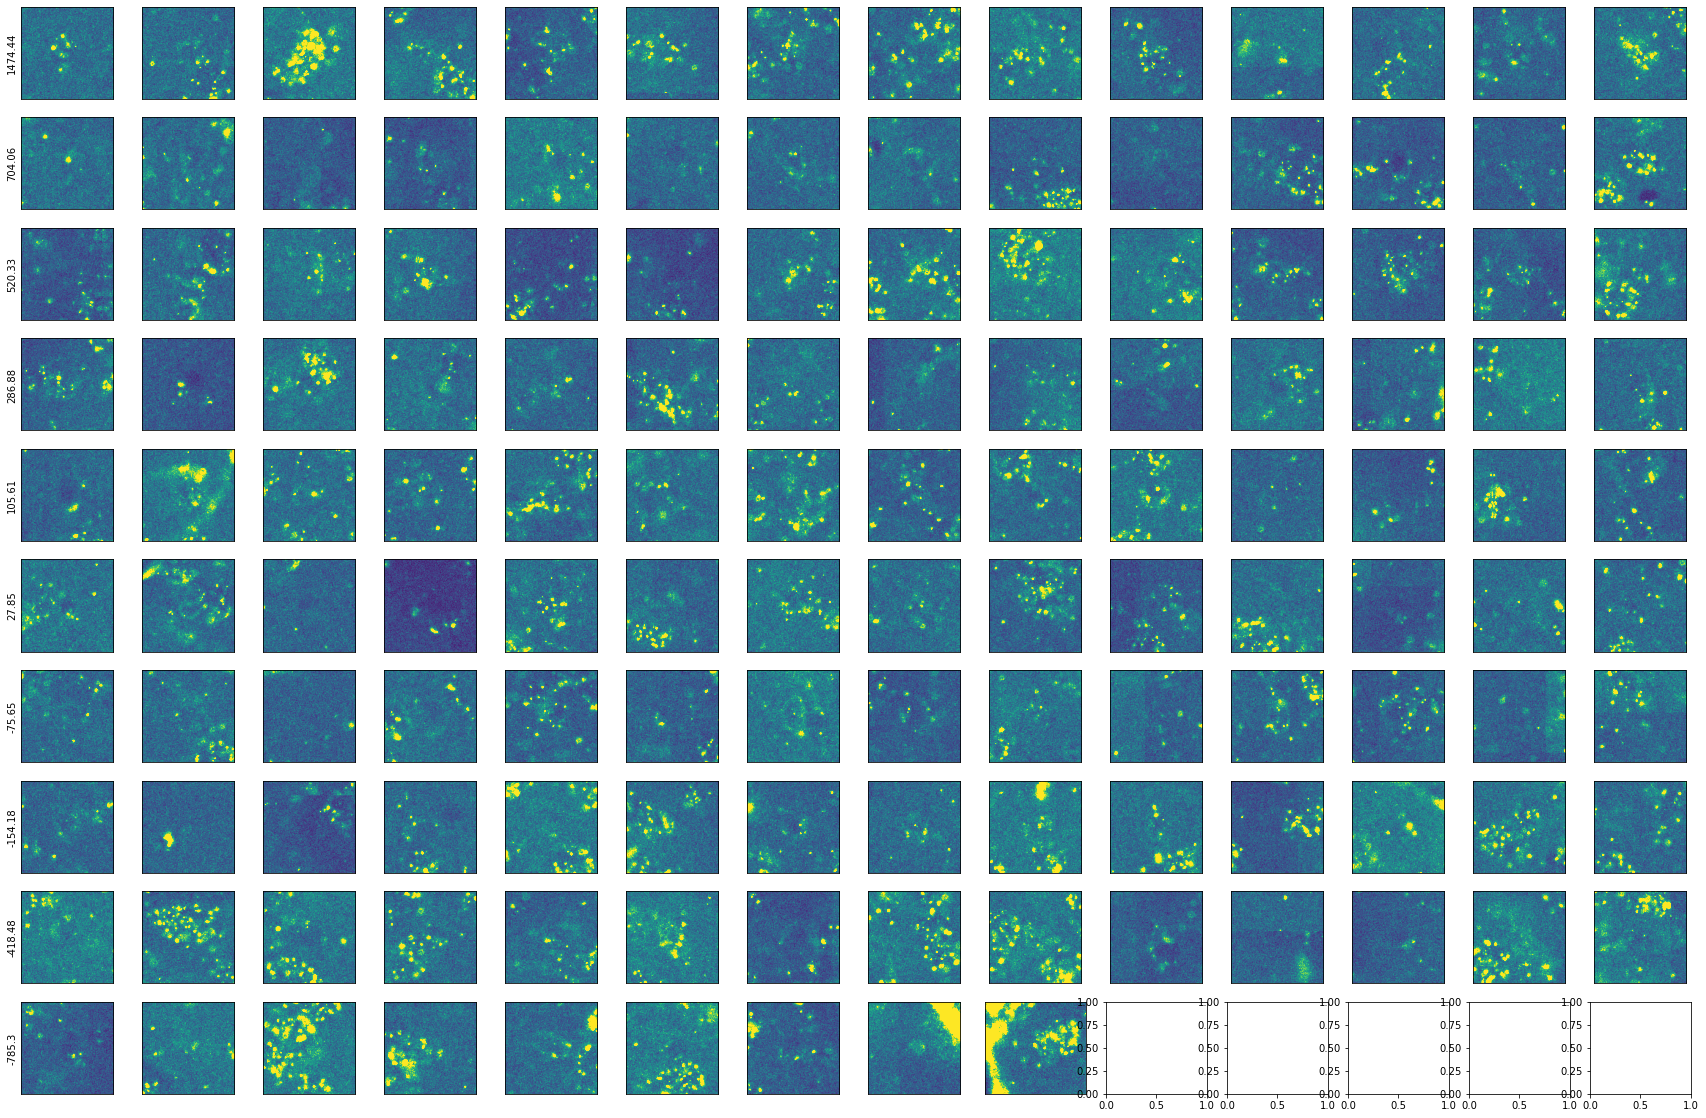

In [379]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import sep
import pickle as pkl
import time
from PIL import Image

n_rows = 10 
n_cols = 14 
size_um = 20 
spine_color_pos = 'r'
spine_width = 2
show_masks = False
max_intensity = None
genes = ['Car4']
pos_cells = []
show_masks = False

# Load metadata
with open('{0}{1}{2}'.format(data_path, sep, metadata_file), 'rb') as f:
    metadata = pkl.load(f)
raw_image_path = metadata['raw_image_path']
filt_image_path = metadata['filt_image_path']
um_per_px = metadata['um_per_px']
n_planes = metadata['n_planes']
h = metadata['h']
w = metadata['w']
base_filename = metadata['base_filename']
channel_names = metadata['channel_names']
if genes == None:
    genes = metadata['genes']

# Load cell pixels
cell_data_file = metadata['cell_data_file']
with open('{0}{1}{2}'.format(data_path, sep, cell_data_file), 'rb') as f:
    cell_data = pkl.load(f)

# Load background pixels
bg_pixels_no_lipo_file = metadata['bg_pixels_no_lipo_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_pixels_no_lipo_file), 'rb') as f:
    bg_pixels_no_lipo = pkl.load(f)

# Load signal
signal_raw_file = metadata['signal_raw_file']
with open('{0}{1}{2}'.format(data_path, sep, signal_raw_file), 'rb') as f:
    signal_raw = pkl.load(f)

signal_filt_file = metadata['signal_filt_file']
with open('{0}{1}{2}'.format(data_path, sep, signal_filt_file), 'rb') as f:
    signal_filt = pkl.load(f)

# Load background
bg_raw_file = metadata['bg_raw_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_raw_file), 'rb') as f:
    bg_raw = pkl.load(f)

bg_filt_file = metadata['bg_filt_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_filt_file), 'rb') as f:
    bg_filt = pkl.load(f)

cells = np.array(list(cell_data.keys()))
t0 = time.time()
for gene in genes:

    sig = signal_raw[gene]
    sig = np.array([np.mean([sig[cell][plane] for plane in sig[cell].keys()]) for cell in sig.keys()])
    sig[np.isnan(sig)] = np.zeros(np.sum(np.isnan(sig)))
    bg = bg_raw[gene]
    bg = np.array([np.mean([bg[cell][plane] for plane in bg[cell].keys()]) for cell in bg.keys()])
    bg[np.isnan(bg)] = np.zeros(np.sum(np.isnan(bg)))
    cell_order = cells[np.flip(np.argsort(sig - bg)).astype(int)]

    size_px = int(size_um/um_per_px/2)
    mask_dil =  np.zeros([h, w]).astype(bool)

    im_array = np.zeros([n_planes, h, w])

    for plane in range(n_planes):
        print('Plane {0}, {1} seconds'.format(plane + 1, np.round(time.time() - t0)))
        img = Image.open('{0}{1}{2}{3}{4}.tif'.format(raw_image_path, sep, base_filename, str(plane + 1).zfill(2),
                                                        channel_names[gene]))
        im_array[plane, :, :] = np.array(img)

    if max_intensity == None:
        max_intensity = np.max(sig)
    min_intensity = np.min(im_array)

    t0 = time.time()
    fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (30, 20))

    for cell in cells:

        if np.mod(cell, 10) == 0:
            print('Cell {0}: {1} seconds'.format(cell, np.round(time.time() - t0)))

        row = int((cell - 1)/n_cols)
        col = np.mod((cell - 1), n_cols)

        cell_id = cell_order[cell - 1]

        planes = cell_data[cell_id]['z_planes']
        med_plane = int(np.median(planes))

        mask = cell_data[cell_id]['masks'][med_plane]
        [x_center, y_center] = np.mean(mask, 0).astype(int)
        [x1, y1] = [np.max([0, x_center - size_px]), np.max([0, y_center - size_px])]
        [x2, y2] = [np.min([h, x_center + size_px]), np.min([w, y_center + size_px])]
        mask_dil[x1:x2, y1:y2] = np.ones([x2 - x1, y2 - y1])

        small_im = np.reshape(im_array[med_plane, mask_dil],
                                        [np.min([x2 - x1, size_px*2]),
                                        np.min([y2 - y1, size_px*2])])
        ax[row, col].imshow(small_im, vmin = min_intensity, vmax = max_intensity)

        mask_dil[x1:x2, y1:y2] = np.zeros([x2 - x1, y2 - y1])
        
        if show_masks:
            
            cell_px = cell_pixels_no_lipo[cell_id][med_plane]
            cell_mask = np.zeros(small_im.shape)
            x = cell_px[0, :] - x1
            y = cell_px[1, :] - y1
#             for i in range(len(x)):
#                 cell_mask[x[i], y[i]] = 1
            cell_mask[x, y] = np.ones(len(x))
            ax[row, col].imshow(cell_mask, vmin = 0, vmax = 1, cmap = 'gray', alpha = 0.2)

        if col == 0:
            ax[row, col].set_ylabel('{0}'.format(np.round(sig[cell_id - 1] - bg[cell_id - 1], 2)))
#             ax[row, col].axis('on')

        if len(pos_cells) > 0:
            if pos_cells[cell] == 1:
                ax[row, col].axis('on')
                ax[row, col].spines['bottom'].set_color(spine_color_pos)
                ax[row, col].spines['top'].set_color(spine_color_pos)
                ax[row, col].spines['left'].set_color(spine_color_pos)
                ax[row, col].spines['right'].set_color(spine_color_pos)
                ax[row, col].spines['bottom'].set_linewidth(spine_width)
                ax[row, col].spines['top'].set_linewidth(spine_width)
                ax[row, col].spines['left'].set_linewidth(spine_width)
                ax[row, col].spines['right'].set_linewidth(spine_width)

        ax[row, col].tick_params(axis = 'both', which = 'both', bottom = False, top = False, left = False,
                                 right = False, labeltop = False, labelright = False, labelleft = False,
                                labelbottom = False)


Plane 1, 0.0 seconds
Plane 2, 1.0 seconds
Plane 3, 2.0 seconds
Plane 4, 3.0 seconds
Plane 5, 4.0 seconds
Plane 6, 5.0 seconds
Plane 7, 6.0 seconds
Plane 8, 7.0 seconds
Plane 9, 8.0 seconds
Plane 10, 9.0 seconds
Cell 10: 2.0 seconds
Cell 20: 2.0 seconds
Cell 30: 3.0 seconds
Cell 40: 4.0 seconds
Cell 50: 4.0 seconds
Cell 60: 5.0 seconds
Cell 70: 6.0 seconds
Cell 80: 6.0 seconds
Cell 90: 7.0 seconds
Cell 100: 8.0 seconds
Cell 110: 8.0 seconds
Cell 120: 9.0 seconds
Cell 130: 10.0 seconds


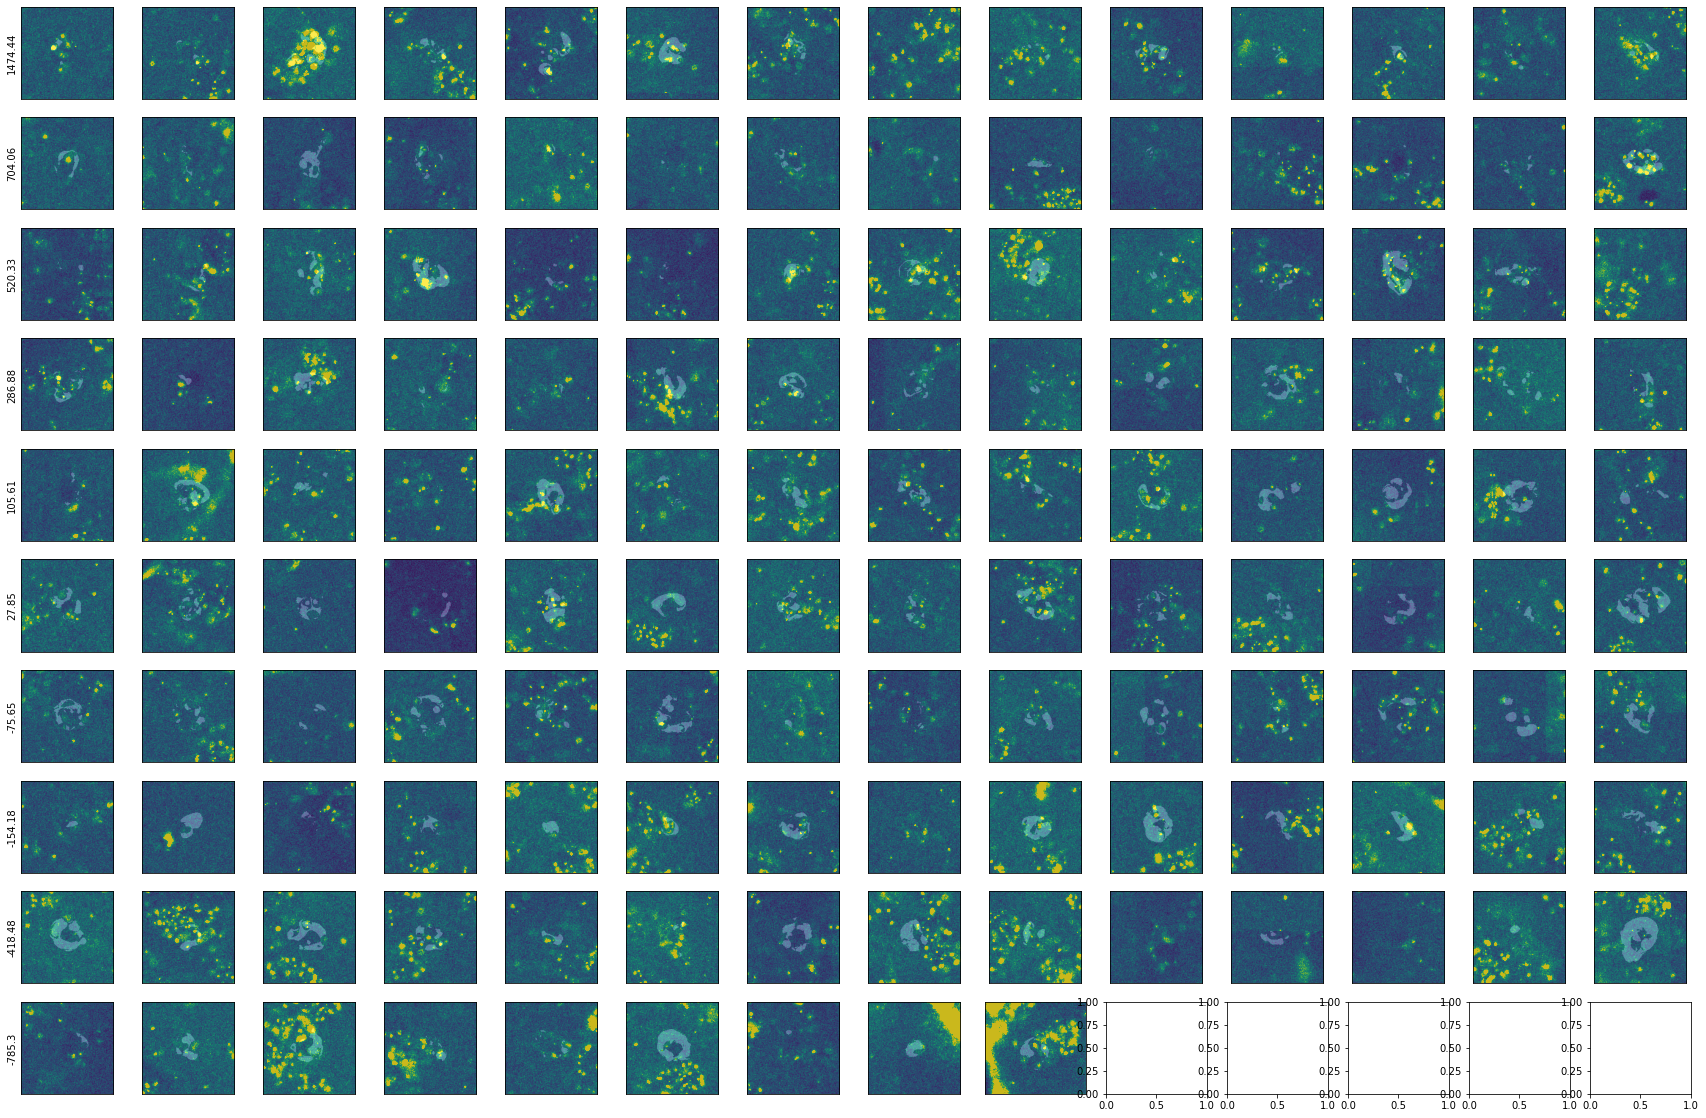

In [378]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import sep
import pickle as pkl
import time
from PIL import Image

n_rows = 10 
n_cols = 14 
size_um = 15 
spine_color_pos = 'r'
spine_width = 2
show_masks = False
max_intensity = None
genes = ['Car4']
pos_cells = []
show_masks = True

# Load metadata
with open('{0}{1}{2}'.format(data_path, sep, metadata_file), 'rb') as f:
    metadata = pkl.load(f)
raw_image_path = metadata['raw_image_path']
filt_image_path = metadata['filt_image_path']
um_per_px = metadata['um_per_px']
n_planes = metadata['n_planes']
h = metadata['h']
w = metadata['w']
base_filename = metadata['base_filename']
channel_names = metadata['channel_names']
if genes == None:
    genes = metadata['genes']

# Load cell pixels
cell_data_file = metadata['cell_data_file']
with open('{0}{1}{2}'.format(data_path, sep, cell_data_file), 'rb') as f:
    cell_data = pkl.load(f)

# Load background pixels
bg_pixels_no_lipo_file = metadata['bg_pixels_no_lipo_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_pixels_no_lipo_file), 'rb') as f:
    bg_pixels_no_lipo = pkl.load(f)

# Load signal
signal_raw_file = metadata['signal_raw_file']
with open('{0}{1}{2}'.format(data_path, sep, signal_raw_file), 'rb') as f:
    signal_raw = pkl.load(f)

signal_filt_file = metadata['signal_filt_file']
with open('{0}{1}{2}'.format(data_path, sep, signal_filt_file), 'rb') as f:
    signal_filt = pkl.load(f)

# Load background
bg_raw_file = metadata['bg_raw_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_raw_file), 'rb') as f:
    bg_raw = pkl.load(f)

bg_filt_file = metadata['bg_filt_file']
with open('{0}{1}{2}'.format(data_path, sep, bg_filt_file), 'rb') as f:
    bg_filt = pkl.load(f)

cells = np.array(list(cell_data.keys()))
t0 = time.time()
for gene in genes:

    sig = signal_raw[gene]
    sig = np.array([np.mean([sig[cell][plane] for plane in sig[cell].keys()]) for cell in sig.keys()])
    sig[np.isnan(sig)] = np.zeros(np.sum(np.isnan(sig)))
    bg = bg_raw[gene]
    bg = np.array([np.mean([bg[cell][plane] for plane in bg[cell].keys()]) for cell in bg.keys()])
    bg[np.isnan(bg)] = np.zeros(np.sum(np.isnan(bg)))
    cell_order = cells[np.flip(np.argsort(sig - bg)).astype(int)]

    size_px = int(size_um/um_per_px/2)
    mask_dil =  np.zeros([h, w]).astype(bool)

    im_array = np.zeros([n_planes, h, w])

    for plane in range(n_planes):
        print('Plane {0}, {1} seconds'.format(plane + 1, np.round(time.time() - t0)))
        img = Image.open('{0}{1}{2}{3}{4}.tif'.format(raw_image_path, sep, base_filename, str(plane + 1).zfill(2),
                                                        channel_names[gene]))
        im_array[plane, :, :] = np.array(img)

    if max_intensity == None:
        max_intensity = np.max(sig)
    min_intensity = np.min(im_array)

    t0 = time.time()
    fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (30, 20))

    for cell in cells:

        if np.mod(cell, 10) == 0:
            print('Cell {0}: {1} seconds'.format(cell, np.round(time.time() - t0)))

        row = int((cell - 1)/n_cols)
        col = np.mod((cell - 1), n_cols)

        cell_id = cell_order[cell - 1]

        planes = cell_data[cell_id]['z_planes']
        med_plane = int(np.median(planes))

        mask = cell_data[cell_id]['masks'][med_plane]
        [x_center, y_center] = np.mean(mask, 0).astype(int)
        [x1, y1] = [np.max([0, x_center - size_px]), np.max([0, y_center - size_px])]
        [x2, y2] = [np.min([h, x_center + size_px]), np.min([w, y_center + size_px])]
        mask_dil[x1:x2, y1:y2] = np.ones([x2 - x1, y2 - y1])

        small_im = np.reshape(im_array[med_plane, mask_dil],
                                        [np.min([x2 - x1, size_px*2]),
                                        np.min([y2 - y1, size_px*2])])
        ax[row, col].imshow(small_im, vmin = min_intensity, vmax = max_intensity)

        mask_dil[x1:x2, y1:y2] = np.zeros([x2 - x1, y2 - y1])
        
        if show_masks:
            
            cell_px = cell_pixels_no_lipo[cell_id][med_plane]
            cell_mask = np.zeros(small_im.shape)
            x = cell_px[0, :] - x1
            y = cell_px[1, :] - y1
#             for i in range(len(x)):
#                 cell_mask[x[i], y[i]] = 1
            cell_mask[x, y] = np.ones(len(x))
            ax[row, col].imshow(cell_mask, vmin = 0, vmax = 1, cmap = 'gray', alpha = 0.3)

        if col == 0:
            ax[row, col].set_ylabel('{0}'.format(np.round(sig[cell_id - 1] - bg[cell_id - 1], 2)))
#             ax[row, col].axis('on')

        if len(pos_cells) > 0:
            if pos_cells[cell] == 1:
                ax[row, col].axis('on')
                ax[row, col].spines['bottom'].set_color(spine_color_pos)
                ax[row, col].spines['top'].set_color(spine_color_pos)
                ax[row, col].spines['left'].set_color(spine_color_pos)
                ax[row, col].spines['right'].set_color(spine_color_pos)
                ax[row, col].spines['bottom'].set_linewidth(spine_width)
                ax[row, col].spines['top'].set_linewidth(spine_width)
                ax[row, col].spines['left'].set_linewidth(spine_width)
                ax[row, col].spines['right'].set_linewidth(spine_width)

        ax[row, col].tick_params(axis = 'both', which = 'both', bottom = False, top = False, left = False,
                                 right = False, labeltop = False, labelright = False, labelleft = False,
                                labelbottom = False)


## All genes

Plane 1, 0.0 seconds
Plane 2, 2.0 seconds
Plane 3, 3.0 seconds
Plane 4, 4.0 seconds
Plane 5, 5.0 seconds
Plane 6, 6.0 seconds
Plane 7, 7.0 seconds
Plane 8, 8.0 seconds
Plane 9, 9.0 seconds
Plane 10, 11.0 seconds
Cell 10: 2.0 seconds


IndexError: index 10 is out of bounds for axis 0 with size 10

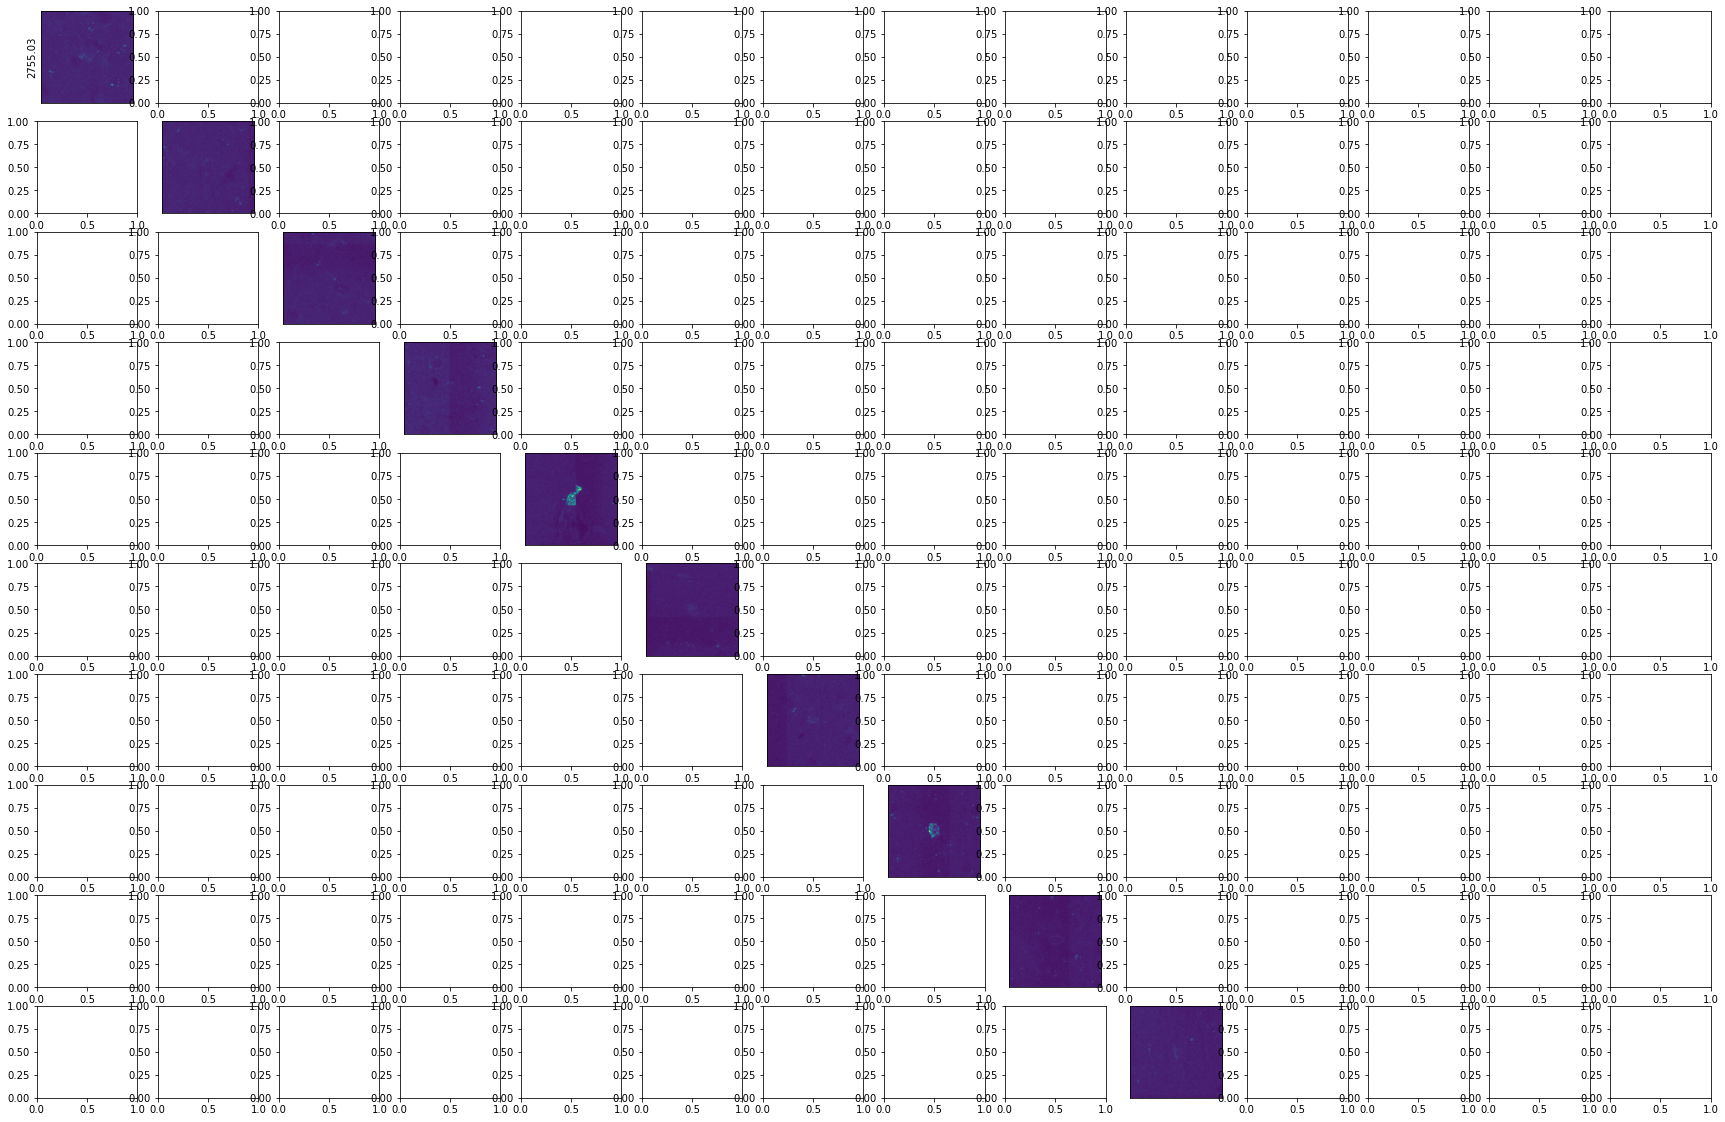

In [369]:
view_all_cells.view_all_cells(data_path, metadata_file, 10, 14, 50, genes = ['Tac2'])

# Reload modules

In [114]:
# Ideally, modules should be auto-reloaded 

importlib.reload(get_metadata)

# Segmentation
importlib.reload(get_masks)
importlib.reload(get_background)

# Lipofuscin
importlib.reload(annotated_lipo_rois)
importlib.reload(filter_lipo)
importlib.reload(detect)

# Plotting
importlib.reload(napari_rendering)
importlib.reload(scatter_plots)
importlib.reload(view_all_cells)

# Expression
importlib.reload(signal_and_bg)

# Classification
importlib.reload(get_labels)

# Cell depths
importlib.reload(get_depths)

# Utils
importlib.reload(diff_gauss)
importlib.reload(find_threshold)

<module 'utils.find_threshold' from 'G:\\Shared drives\\as_share\\HCR\\FISH Image Analysis\\utils\\find_threshold.py'>

# Debugging

In [89]:
crop = viewer.add_shapes(data = None)


Filtering Vip images: 0.0 seconds
Plane 3, 0.0 seconds


Text(0.5, 1.0, 'saved tiff image')

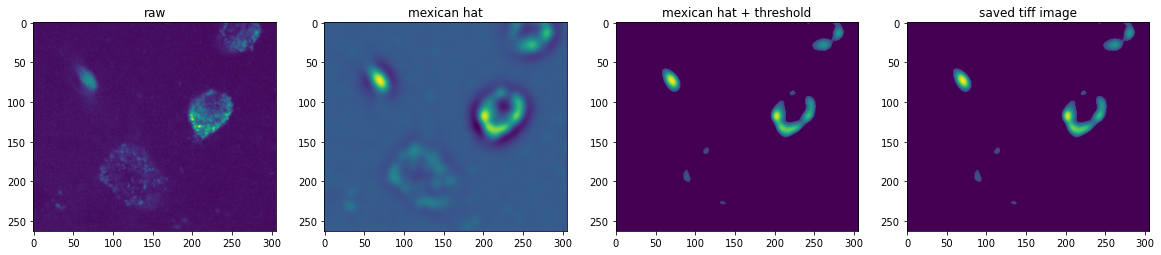

In [94]:
#filter_lipo

import time
import pickle as pkl
from os.path import sep
from PIL import Image
from utils import diff_gauss
from utils import find_threshold
from tifffile import imwrite
from segmentation import get_masks
import numpy as np

#genes = None
genes = ['Vip']
#planes = None
rect = crop.data[-1]
planes = [int(rect[0, 0])]

sigma_small = 5
sigma_large = 10
thresh_scale = 1
save_tiffs = False

# Load metadata
with open('{0}{1}{2}'.format(data_path, sep, metadata_file), 'rb') as f:
    metadata = pkl.load(f)

raw_image_path = metadata['raw_image_path']
filt_image_path = metadata['filt_image_path']

#n_planes = metadata['n_planes']
if planes == None:
    planes = list(range(metadata['n_planes']))
n_planes = len(planes)

h = metadata['h']
w = metadata['w']
base_filename = metadata['base_filename']
channel_names = metadata['channel_names']
if genes == None:
    genes = metadata['genes']
    
# Load cell pixels
cell_pixels_file = metadata['cell_pixels_file']
with open('{0}{1}{2}'.format(data_path, sep, cell_pixels_file), 'rb') as f:
    cell_pixels = pkl.load(f)

t0 = time.time()
im_thresh = np.zeros([h, w])
for gene in genes:
    print('')
    print('Filtering {0} images: {1} seconds'.format(gene, np.round(time.time() - t0)))

    for plane in planes:
        print('Plane {0}, {1} seconds'.format(plane + 1, np.round(time.time() - t0)))
        img = Image.open('{0}{1}{2}{3}{4}.tif'.format(raw_image_path, sep, base_filename, str(plane + 1).zfill(2),
                                                        channel_names[gene]))
        im_array = np.array(img)
        im_diff = diff_gauss.diff_gauss(sigma_small, sigma_large, im_array)

        px = all_cell_pixels[all_cell_pixels[:, 0] == plane, 1:]
        points = im_diff[px[:, 0], px[:, 1]]
        thresh = find_threshold.find_threshold(points, thresh_scale)

        ix = np.where(im_diff > thresh)
        im_thresh[ix] = im_diff[ix]
        
        im_thresh_save = (im_thresh*65536/np.max(im_thresh)).astype(np.int16)

#x1 = 4284; x2 = x1 + 130; y1 = 1143; y2 = y1 + 160
x1 = int(rect[0, 1])
x2 = int(rect[1, 1])
y1 = int(rect[0, 2])
y2 = int(rect[2, 2])
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = [20, 20])

ax[0].imshow(im_array[x1:x2, y1:y2])
ax[0].set_title('raw')
ax[1].imshow(im_diff[x1:x2, y1:y2])
ax[1].set_title('mexican hat')
ax[2].imshow(im_thresh[x1:x2, y1:y2])
ax[2].set_title('mexican hat + threshold')
ax[3].imshow(im_thresh_save[x1:x2, y1:y2])
ax[3].set_title('saved tiff image')



In [95]:
imwrite('{0}{1}{2}_plane{3}_filt_sigma={4},{5}_thresh={6}_new.tif'.format(filt_image_path, sep, gene,
                                                                                    str(plane + 1).zfill(2),
                                                                                    sigma_small, sigma_large,
                                                                                    thresh_scale),
                                                                                    im_thresh_save)

In [81]:
metadata['lipo_thresh_scale']

1

In [90]:
crop.data

[array([[2.00000000e+00, 2.78823170e+03, 1.63075997e+03],
        [2.00000000e+00, 3.05166055e+03, 1.63075997e+03],
        [2.00000000e+00, 3.05166055e+03, 1.93616951e+03],
        [2.00000000e+00, 2.78823170e+03, 1.93616951e+03]])]